<a href="https://colab.research.google.com/github/lauramenicacci/patent_breakdetection/blob/main/REGPAT_scoping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data collection from OECD Patent Database

Collect disaggregated patent raw data from OECD STI [Micro-data Lab](https://www.oecd.org/sti/intellectual-property-statistics-and-analysis.htmOECD/STI). 

* OECD REGPAT DATABASE - EPO & PCT Patent Applications at Regional Level
* OECD Citations Database 
* OECD Patent Quality Indicators 

add citations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Import libraries 

In [ ]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


 ## REGPAT - EPO 
 
Collect regional patent data filed at the EPO.
 - State level 
 - TL2 regional classification (CITE OECD) 
 - 51 regions 

In [ ]:
regpat_regions = pd.read_csv('/content/REGPAT_REGIONS.txt', encoding = 'utf-8', sep = "|") # table with description of regional codes 

In [ ]:
epo_inventors_filt = pd.read_csv('/content/drive/MyDrive/epo_inventors_filt.csv', encoding = 'utf-8', sep = ',') # List of EPO inventors: contains appl_id

In [ ]:
cpc_class = pd.read_csv("/content/drive/MyDrive/202208_CPC_Classes.txt",  encoding = "utf-8", sep = "|") # list of CPC classes related to the invention

In [ ]:
cpc_y02e = pd.read_csv('/content/cpc_y02e.csv')

In [ ]:
epo_ipc = pd.read_csv("/content/drive/MyDrive/202208_EPO_IPC.txt", encoding = "utf-8", sep = "|") 

### Filter by Y02E class

In [ ]:
cpc_y02e = cpc_class[cpc_class['CPC_Class'].str.startswith('Y02E')]

In [ ]:
len(cpc_y02e)

352222

In [ ]:
cpc_y02e.to_csv('cpc_y02e.csv', index = False)

### Join with list of IPC classes and CPC classes

In [ ]:
merged_ipc_cpc = pd.merge(epo_ipc, cpc_y02e, how='left', on= 'appln_id')

merged_ipc_cpc = merged_ipc_cpc.dropna()

len(merged_ipc_cpc)

### Merge regional US data with years and cpc class 

In [ ]:
# merge regpat regions and epo inventors data using ctry_code & reg_code

regpat_regions.rename(columns = {'Ctry_code':'ctry_code'}, inplace = True) # rename col

merged1 = pd.merge(epo_inventors_filt, regpat_regions, how='left', on=['ctry_code', 'reg_code'])

merged1 = merged1.drop_duplicates()

merged1.head() # we have now application id and TL2 regions in the same df

,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label
0,EP20000103094,1,FI197,FI,1.0,0.250000,Pirkanmaa,FI19,Western Finland
4,EP20000107845,2,UKH12,GB,1.0,0.166667,Cambridgeshire CC,UKH,East of England
6,EP20000107845,2,US06001,US,1.0,0.166667,"Alameda County, CA",US06,California
9,EP20000107845,2,AU1GS,AU,1.0,0.166667,Sydney,AU1,New South Wales
10,EP20000202556,3,DEA2D,DE,1.0,0.333333,Aachen region,DEA2,Köln


In [ ]:
len(merged1)

6132206

In [ ]:
merged1_us = merged1.loc[merged1['ctry_code'] == 'US', ] # filter for US only

merged2 = pd.merge(merged1_us, merged_ipc_cpc, how='left', on= 'appln_id') # merge Y02E class & year data with US regional data 

regpat_epo = merged2.dropna() # we drop NAs because they are only present in time and CPC class = means that those invetions were not Y02E

regpat_epo = regpat_epo.astype({'prio_year':'int', 'app_year':'int'})

regpat_epo.head()

,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,app_year,IPC,CPC_Class
95,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,B62B003/14,Y02E 60/10
96,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/00,Y02E 60/10
97,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/08,Y02E 60/10
98,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/10,Y02E 60/10
99,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K017/00,Y02E 60/10


In [ ]:
len(regpat_epo.loc[:,'appln_id'].unique()) # number of US inventions under Y02E class filed at EPO

27577

In [ ]:
regpat_epo.to_csv('epo_regpat_agg.csv', sep = ',', index = False)

## Create patent counts

In [ ]:
epo = pd.read_csv("/content/epo_regpat_agg.csv")

In [ ]:
epo_filt = epo[['Up_reg_label', 'prio_year','inv_share', 'appln_id']].drop_duplicates()

In [ ]:
len(epo_filt)

35001

In [ ]:
epo_filt.head()

,Up_reg_label,prio_year,inv_share,appln_id
0,Texas,1996,0.50,1297
10,Ohio,1996,0.50,1297
20,Indiana,2002,0.25,1357
37,Massachusetts,2002,0.25,1357
71,Tennessee,2002,0.20,1433


In [ ]:
epo_count = epo_filt.groupby(['Up_reg_label', 'prio_year', ], as_index = False).inv_share.sum()

epo_count.head()

,Up_reg_label,prio_year,inv_share
0,Alabama,1978,0.50
1,Alabama,1986,1.00
2,Alabama,1988,0.25
3,Alabama,1989,0.20
4,Alabama,1991,1.00


In [ ]:
epo_count.to_csv('epo_patent_counts.csv', sep = ",", index = False)

### Data exploration - US EPO

Time series of the 50 US states 

Text(0.5, 1, 'REGPAT patent regional share - US State level')

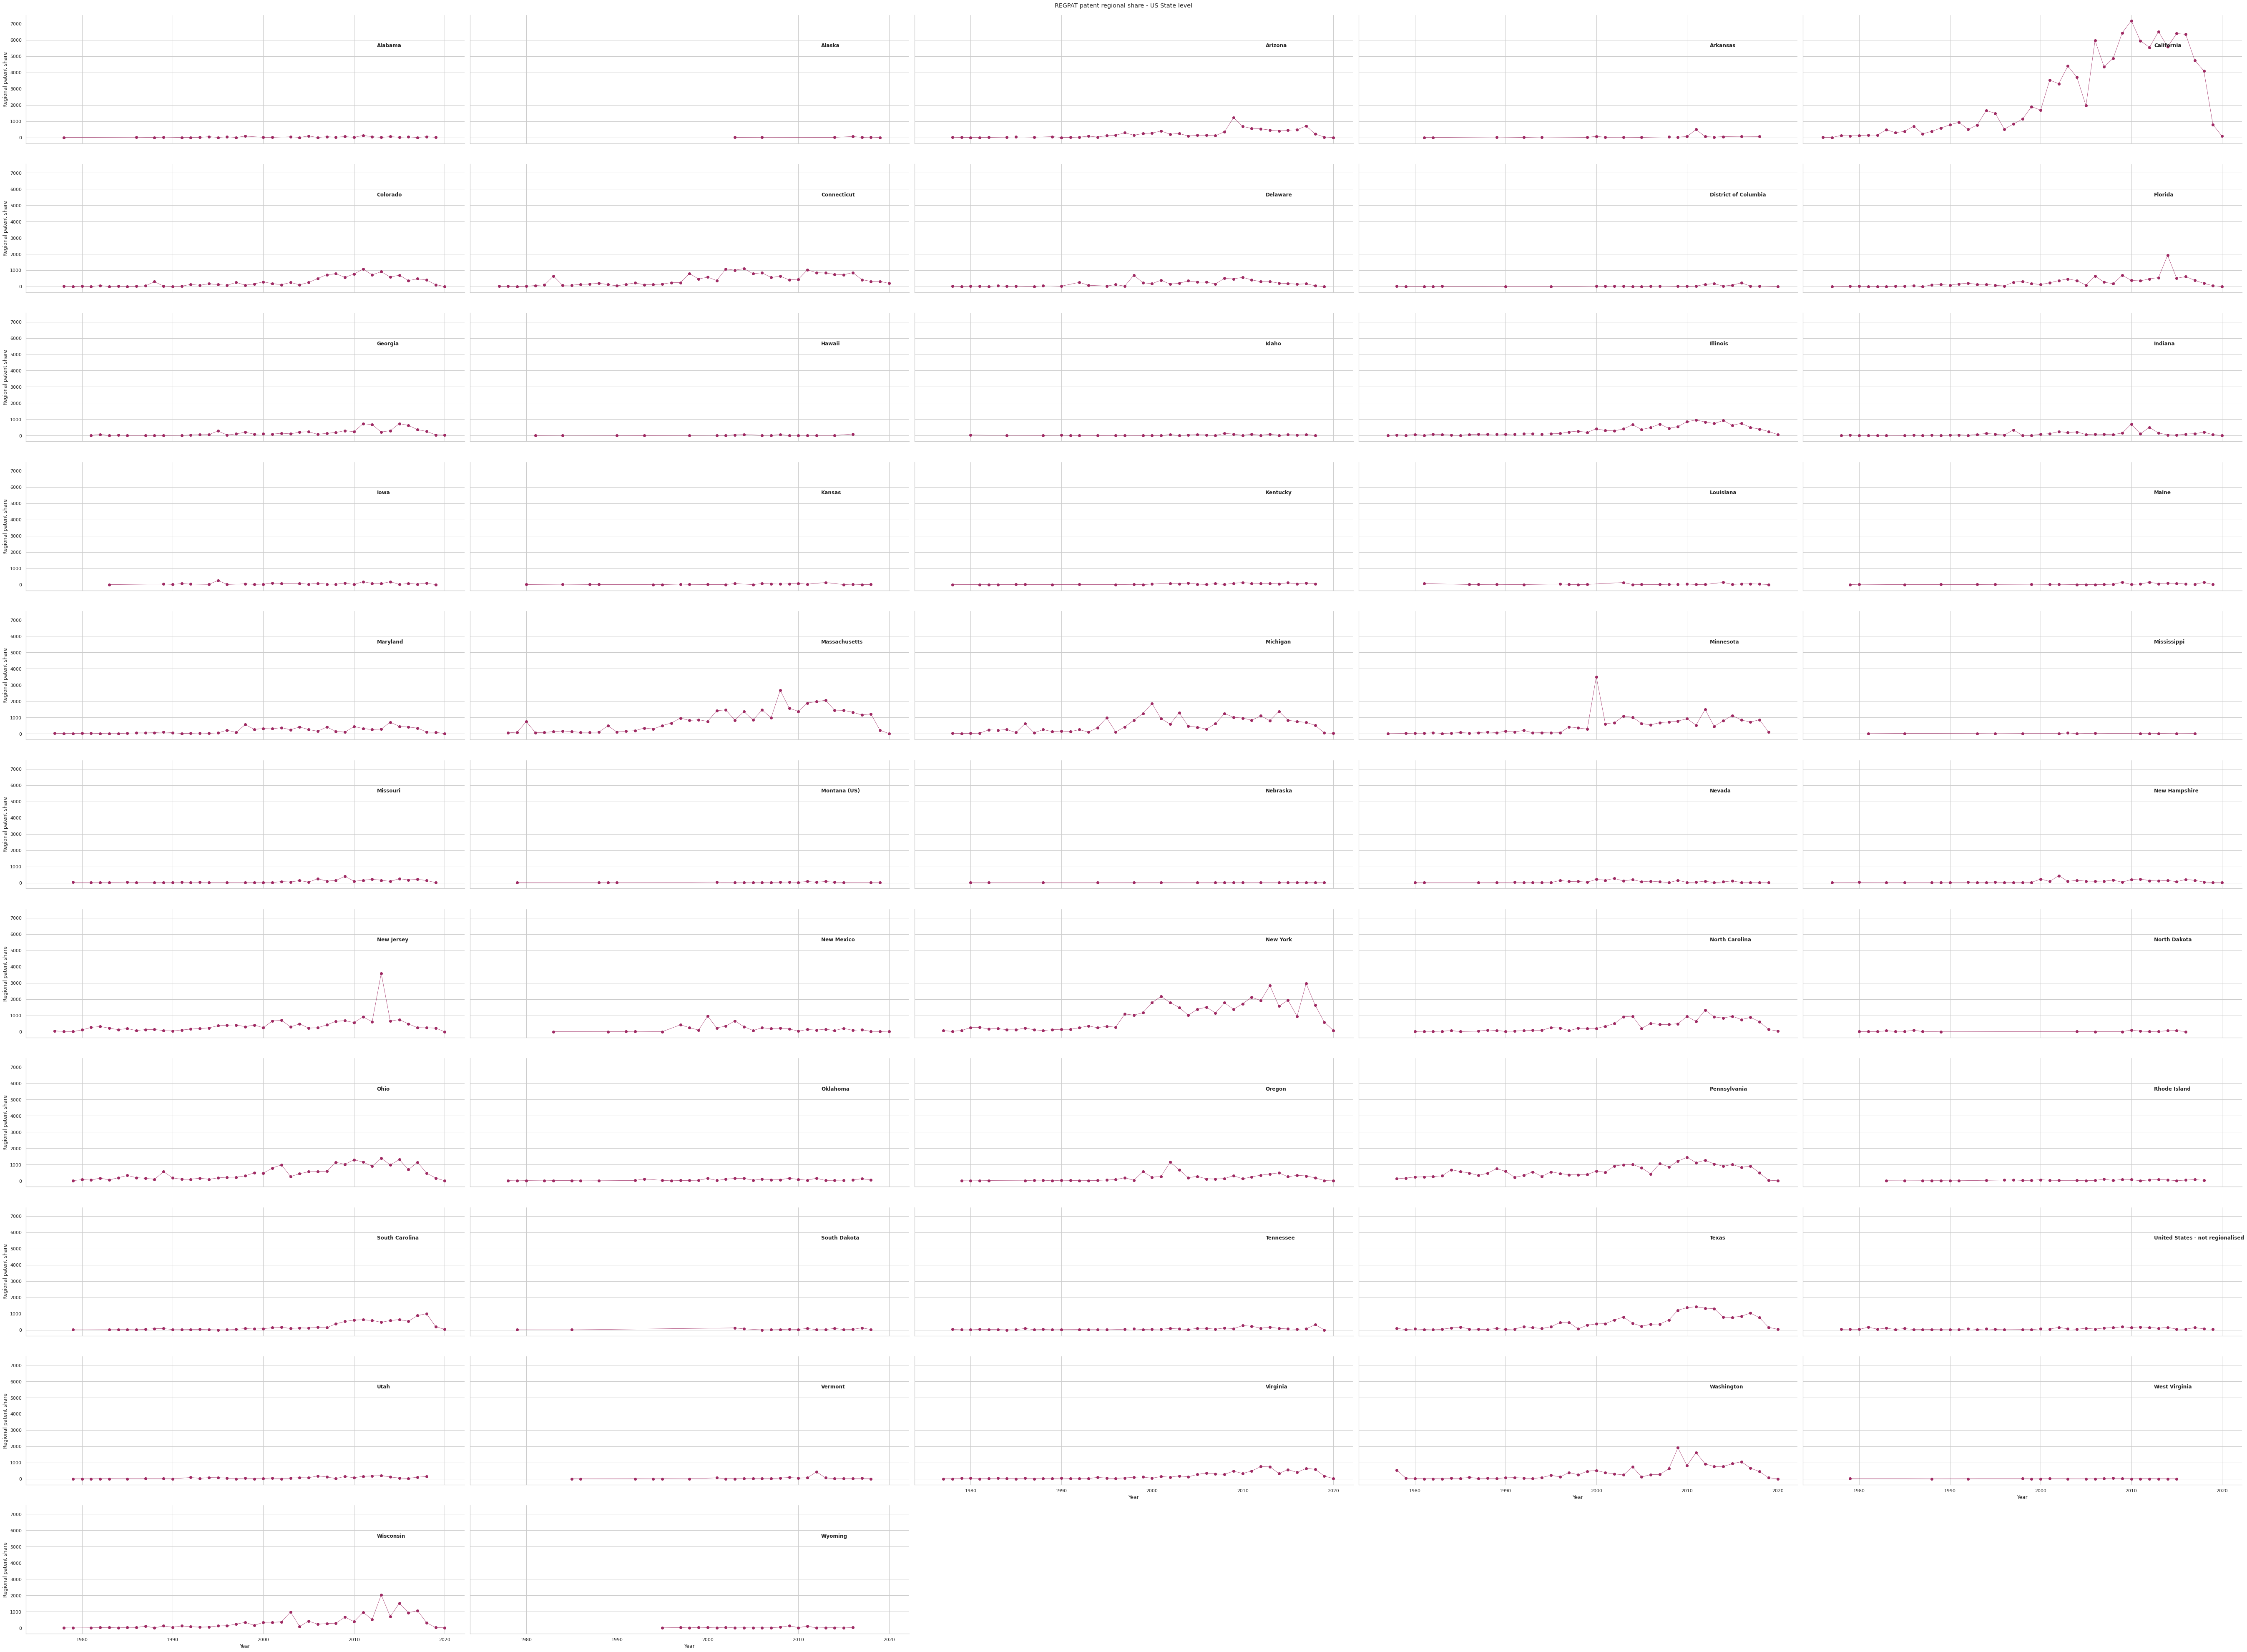

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Plot the lines on two facets
g = sns.relplot(
    data=new_count,
    x="prio_year", y= "appln_id", 
    col="Up_reg_label",
    kind="scatter", 
    palette= "tab20c",
    col_wrap= 5,
    markers = True,
    linewidth=0.5,
    height=5, aspect=3, facet_kws=dict(sharex=True, sharey = True))

# Iterate over each subplot to customize further
for Up_reg_label, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, Up_reg_label, transform=ax.transAxes, fontweight="bold") 

# Add lineplot
g.map(plt.plot, "prio_year", "appln_id", marker="o", color = "#9f2a63", linewidth=0.7)

g.set_axis_labels(x_var="Year", y_var="Regional patent share")

g.set_titles("")
g.figure.suptitle("REGPAT patent regional share - US State level", y= 1)

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


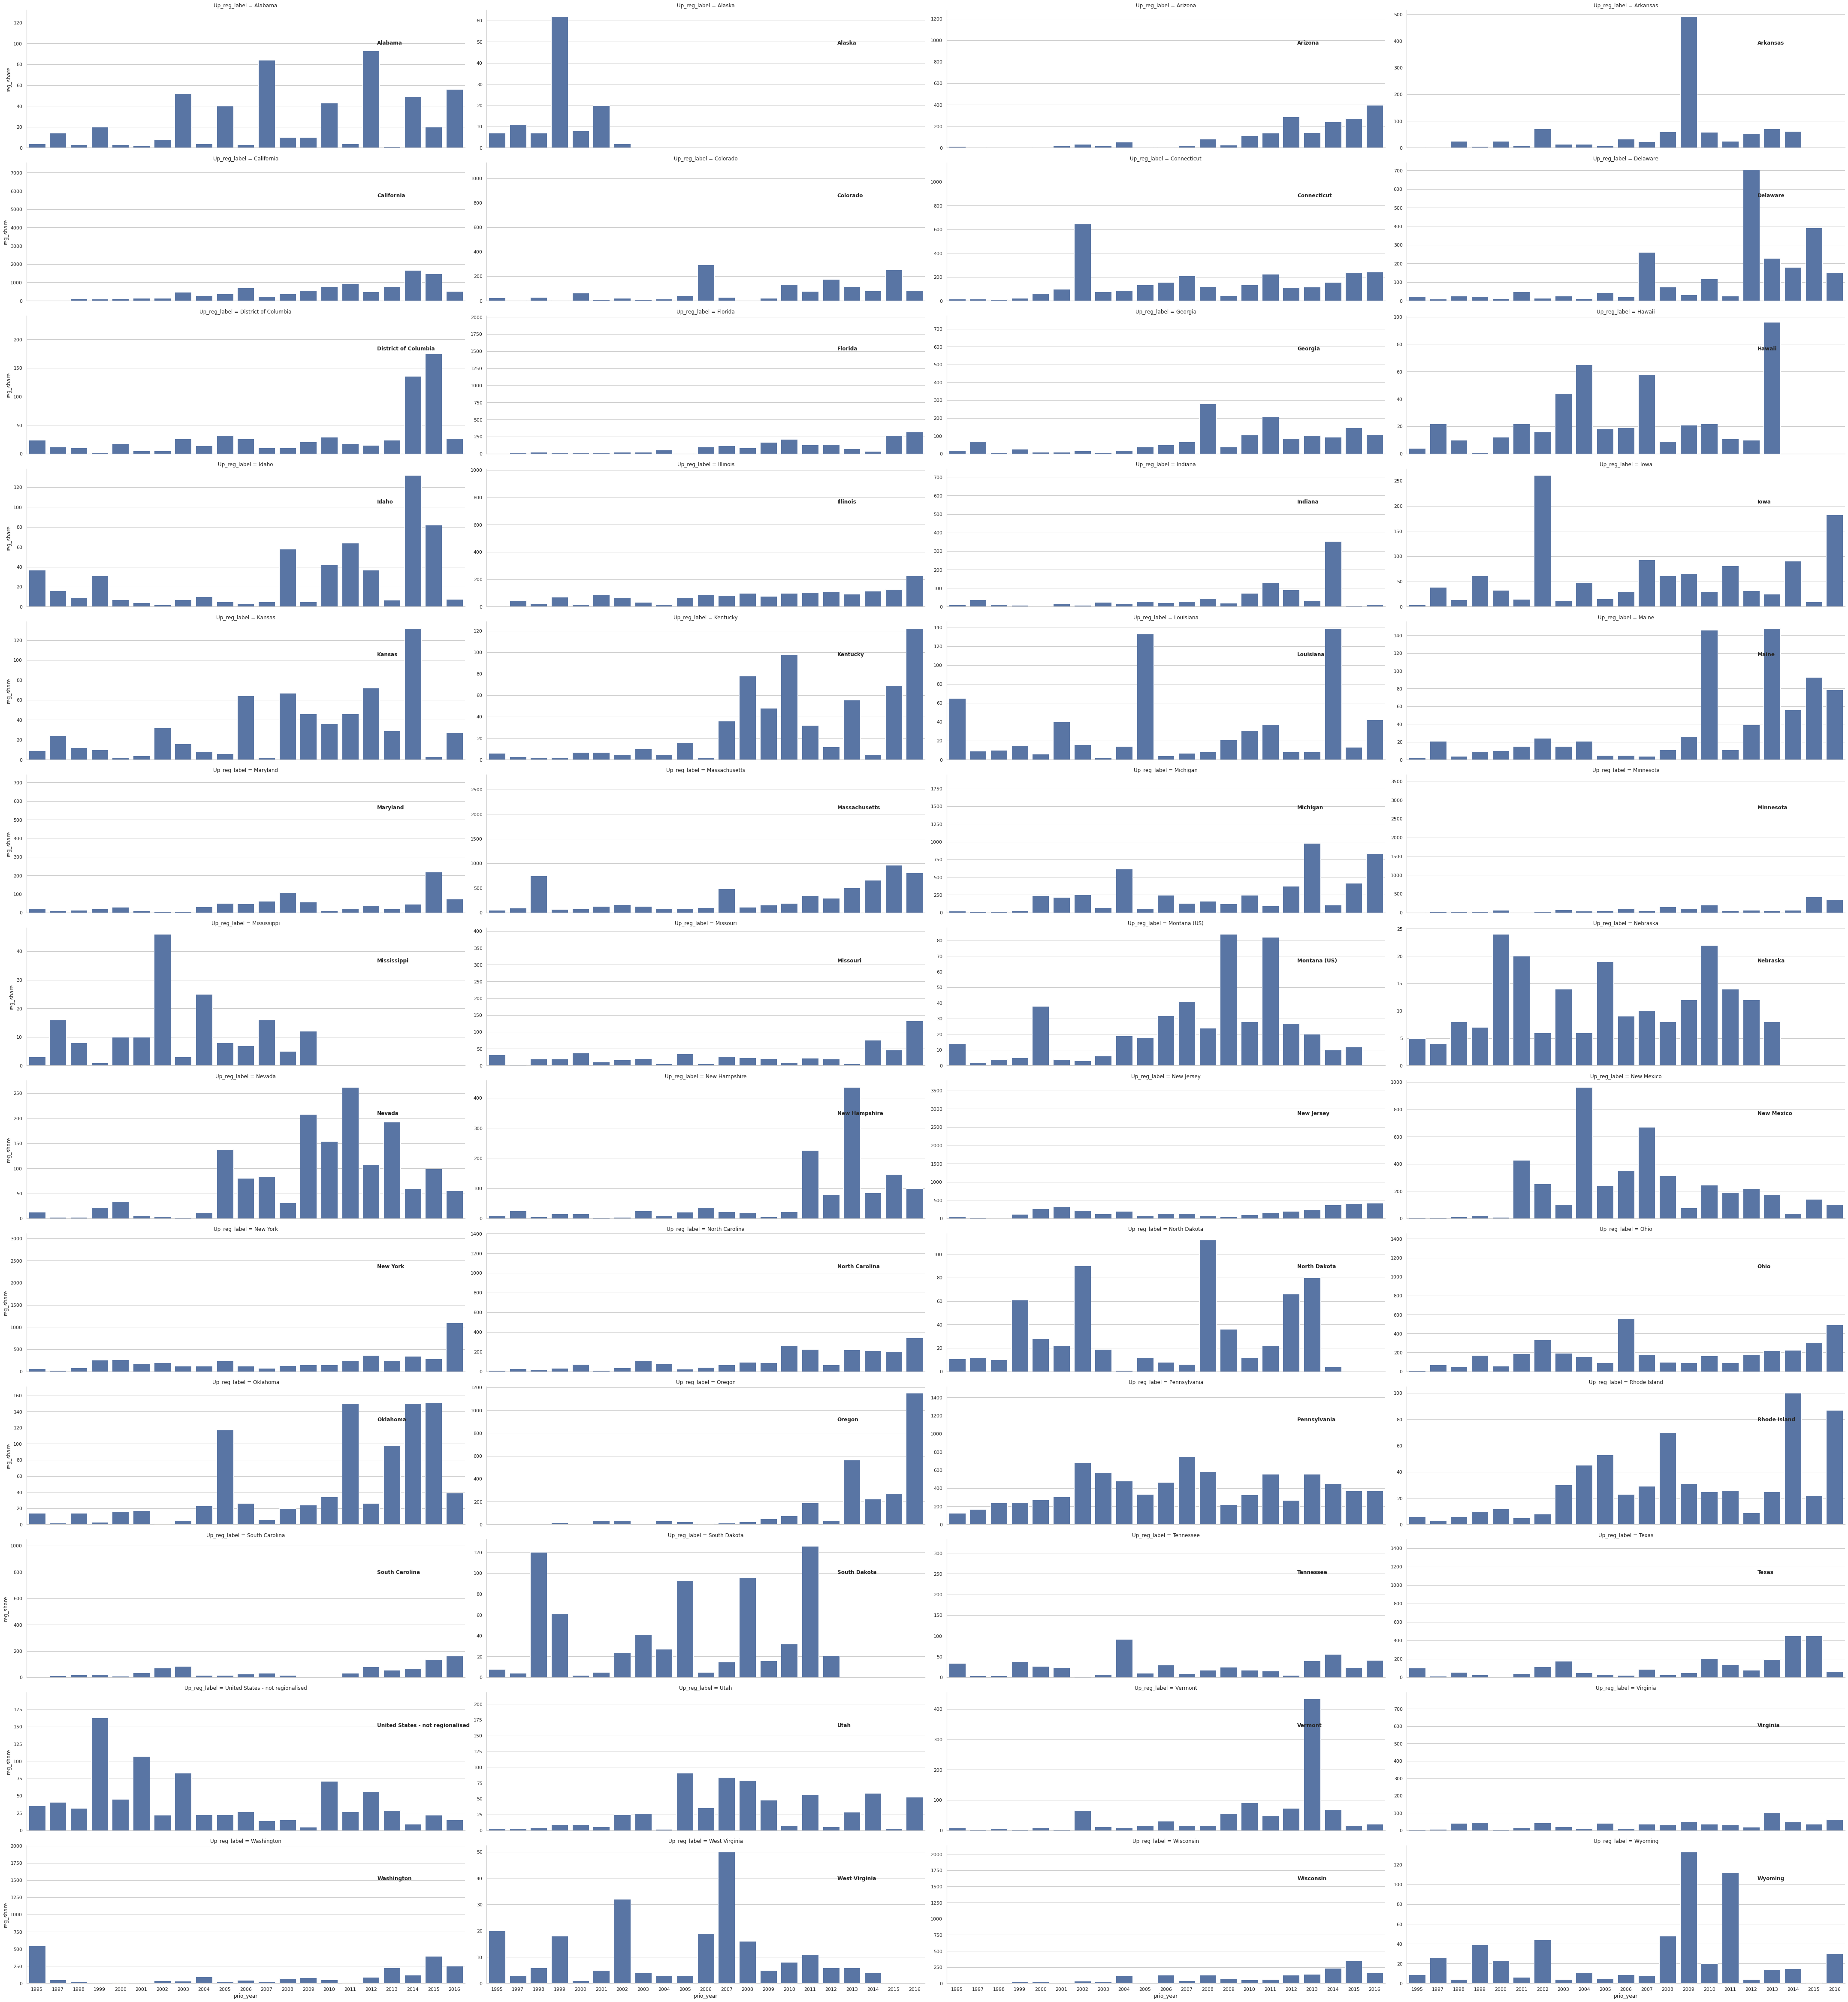

In [ ]:
us = sns.FacetGrid(df_group, col='Up_reg_label', col_wrap=4, height=5, aspect=3, sharey = False, sharex = True, palette = "tab20c", xlim = (1976, 2019)) 
us.map(sns.barplot, 'prio_year', 'reg_share', order= [])

# Iterate over each subplot to customize further
for ctry_code, ax in us.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

### Inspection of EU countries 

In [ ]:
merged_eu = merged1.loc[merged1['ctry_code'].isin(['AT', 'BE', 'BG','CH', 'CZ', 'CY', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE',
      'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI', 'SK', 'MT', 'RO'])]

In [ ]:
merged_eu = pd.merge(merged_eu, merged_ipc_cpc, how='left', on= 'appln_id')

In [ ]:
merged_eu = merged_eu.dropna()

In [ ]:
merged_eu.isna().value_counts()

app_nbr  appln_id  reg_code  ctry_code  reg_share  inv_share  reg_label  Up_reg_code  Up_reg_label  prio_year  app_year  IPC    CPC_Class
False    False     False     False      False      False      False      False        False         True       True      True   True         4197612
                                                                                                    False      False     False  False         665967
                                                              True       True         True          True       True      True   True            8433
                                                                                                    False      False     False  False            791
dtype: int64

In [ ]:
len(merged_eu)

665967

In [ ]:
merged_eu.head(30)

,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,app_year,IPC,CPC_Class
179,EP20060112594,103,CH040,CH,1.0,1.000000,Zürich,CH04,Zürich,2005.0,2006.0,F01D015/10,Y02E 20/16
180,EP20060112594,103,CH040,CH,1.0,1.000000,Zürich,CH04,Zürich,2005.0,2006.0,F01D019/00,Y02E 20/16
181,EP20060112594,103,CH040,CH,1.0,1.000000,Zürich,CH04,Zürich,2005.0,2006.0,F01K021/04,Y02E 20/16
182,EP20060112594,103,CH040,CH,1.0,1.000000,Zürich,CH04,Zürich,2005.0,2006.0,F02C003/22,Y02E 20/16
183,EP20060112594,103,CH040,CH,1.0,1.000000,Zürich,CH04,Zürich,2005.0,2006.0,F02C007/27,Y02E 20/16
273,EP20070015148,146,DEF0D,DE,1.0,0.333333,Segeberg,DEF0,Schleswig-Holstein,2006.0,2007.0,F03D007/04,Y02E 10/72
274,EP20070015148,146,DEF0D,DE,1.0,0.333333,Segeberg,DEF0,Schleswig-Holstein,2006.0,2007.0,F03D007/04,Y02E 10/76
275,EP20070015148,146,DEF0D,DE,1.0,0.333333,Segeberg,DEF0,Schleswig-Holstein,2006.0,2007.0,F03D009/00,Y02E 10/72
276,EP20070015148,146,DEF0D,DE,1.0,0.333333,Segeberg,DEF0,Schleswig-Holstein,2006.0,2007.0,F03D009/00,Y02E 10/76
277,EP20070015148,146,DEF0D,DE,1.0,0.333333,Segeberg,DEF0,Schleswig-Holstein,2006.0,2007.0,H02J003/18,Y02E 10/72


In [ ]:
eu_plot = merged_eu[['ctry_code', 'prio_year','reg_share']]  

eu_group = eu_plot.groupby(['ctry_code', 'prio_year'], as_index = False).reg_share.sum()

In [ ]:
eu_group = eu_group.astype({'prio_year':'string'})
print(eu_group.dtypes)

NameError: ignored

Text(0.5, 1, 'REGPAT patent regional share - EU 27')

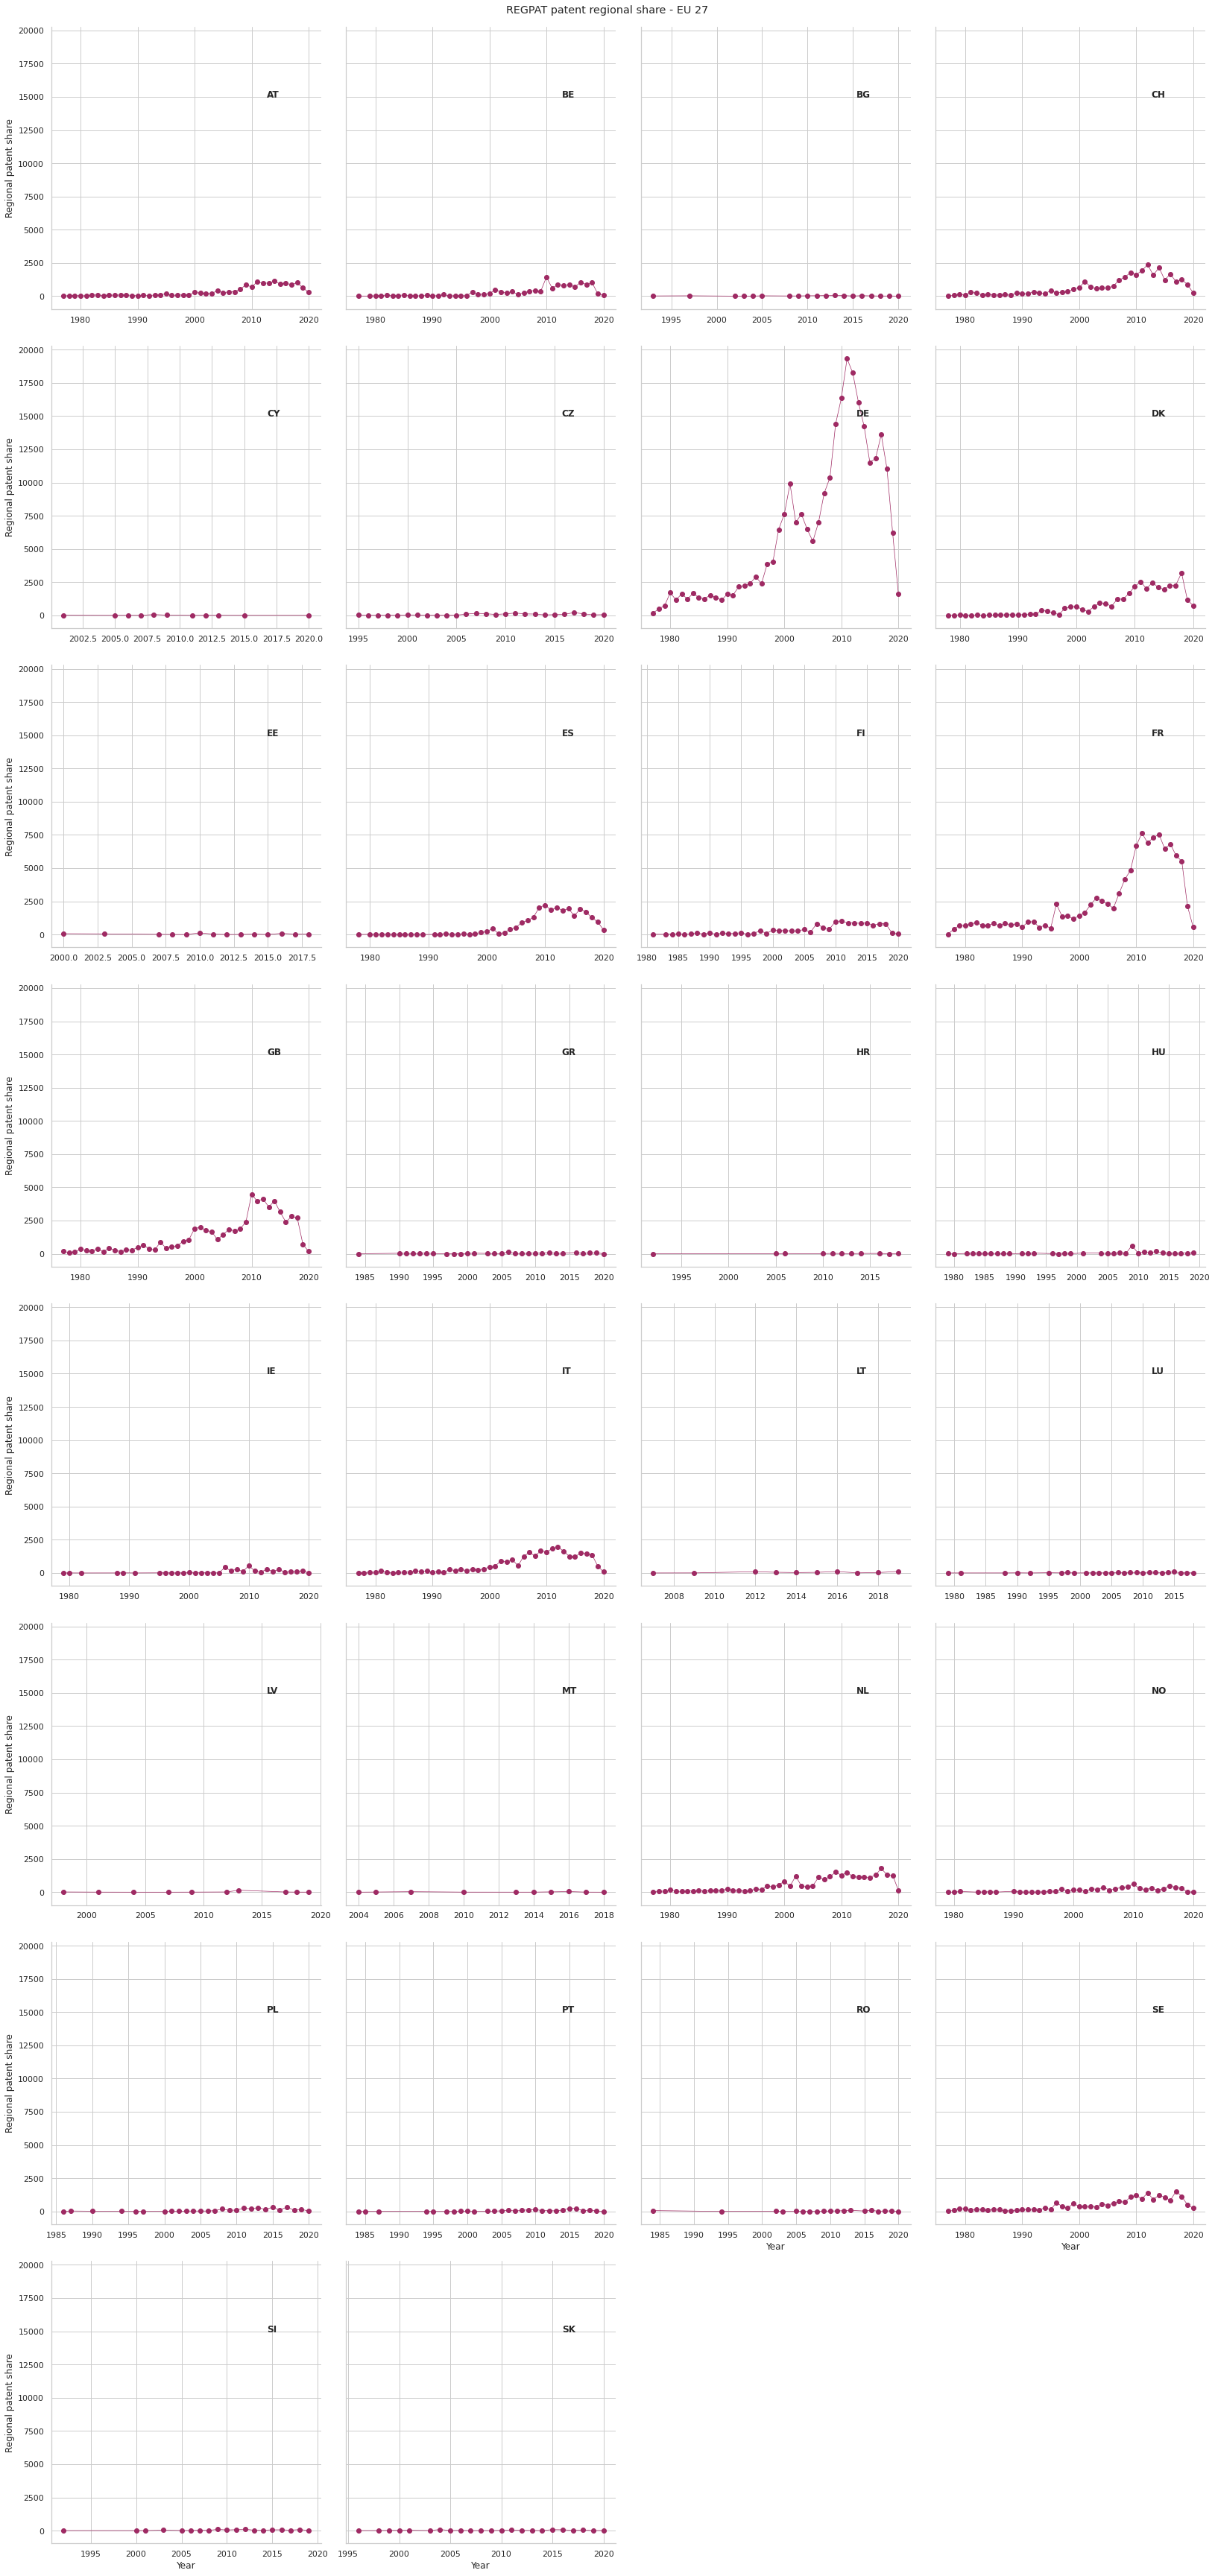

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Plot the lines on two facets
eu = sns.relplot(
    data=eu_group,
    x="prio_year", y= "reg_share", 
    col="ctry_code",
    kind="scatter", 
    palette= "tab20c",
    col_wrap= 4,
    markers = True,
    linewidth=0.5,
    height=6, aspect=.95, facet_kws=dict(sharex=False))

# Iterate over each subplot to customize further
for ctry_code, ax in eu.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

# Add lineplot
eu.map(plt.plot, "prio_year", "reg_share", marker="o", color = "#9f2a63", linewidth=0.7)

eu.set_axis_labels(x_var="Year", y_var="Regional patent share")

eu.set_titles("")
eu.figure.suptitle("REGPAT patent regional share - EU 27", y= 1)

Text(0.5, 1, 'REGPAT patent regional share - EU 27')

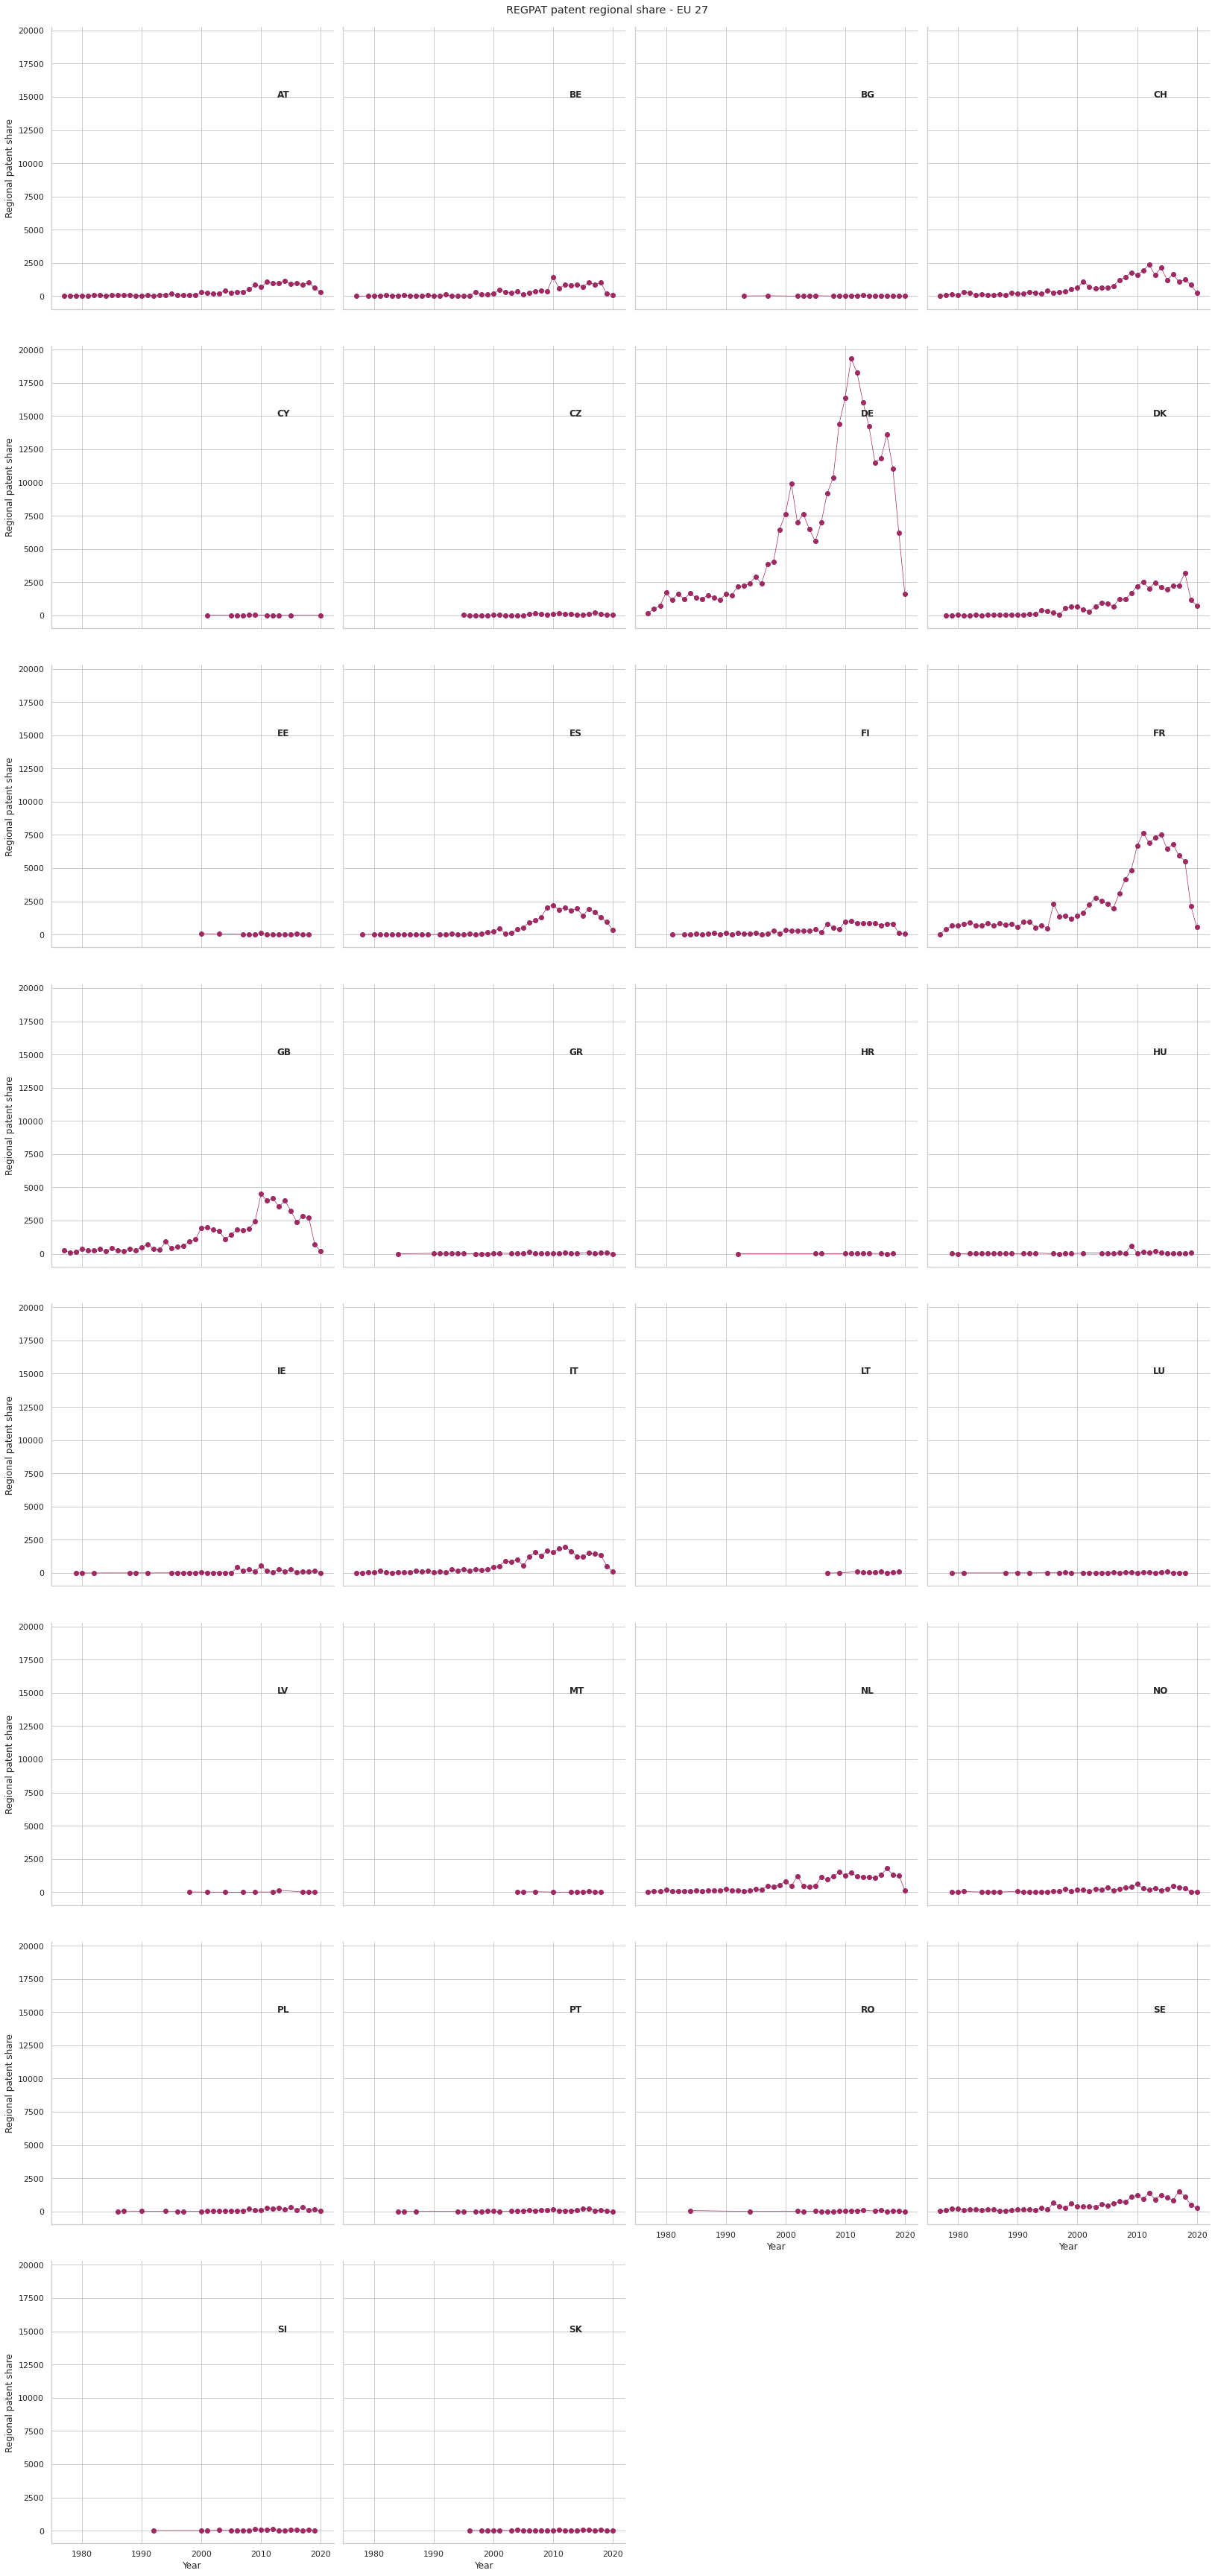

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Plot the lines on two facets
eu = sns.relplot(
    data=eu_group,
    x="prio_year", y= "reg_share", 
    col="ctry_code",
    kind="scatter", 
    palette= "tab20c",
    col_wrap= 4,
    markers = True,
    linewidth=0.5,
    height=6, aspect=.95, facet_kws=dict(sharex=True))

# Iterate over each subplot to customize further
for ctry_code, ax in eu.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

# Add markers
eu.map(plt.plot, "prio_year", "reg_share", marker="o", color = "#9f2a63", linewidth=0.7)

eu.set_axis_labels(x_var="Year", y_var="Regional patent share")

eu.set_titles("")
eu.figure.suptitle("REGPAT patent regional share - EU 27", y= 1)

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


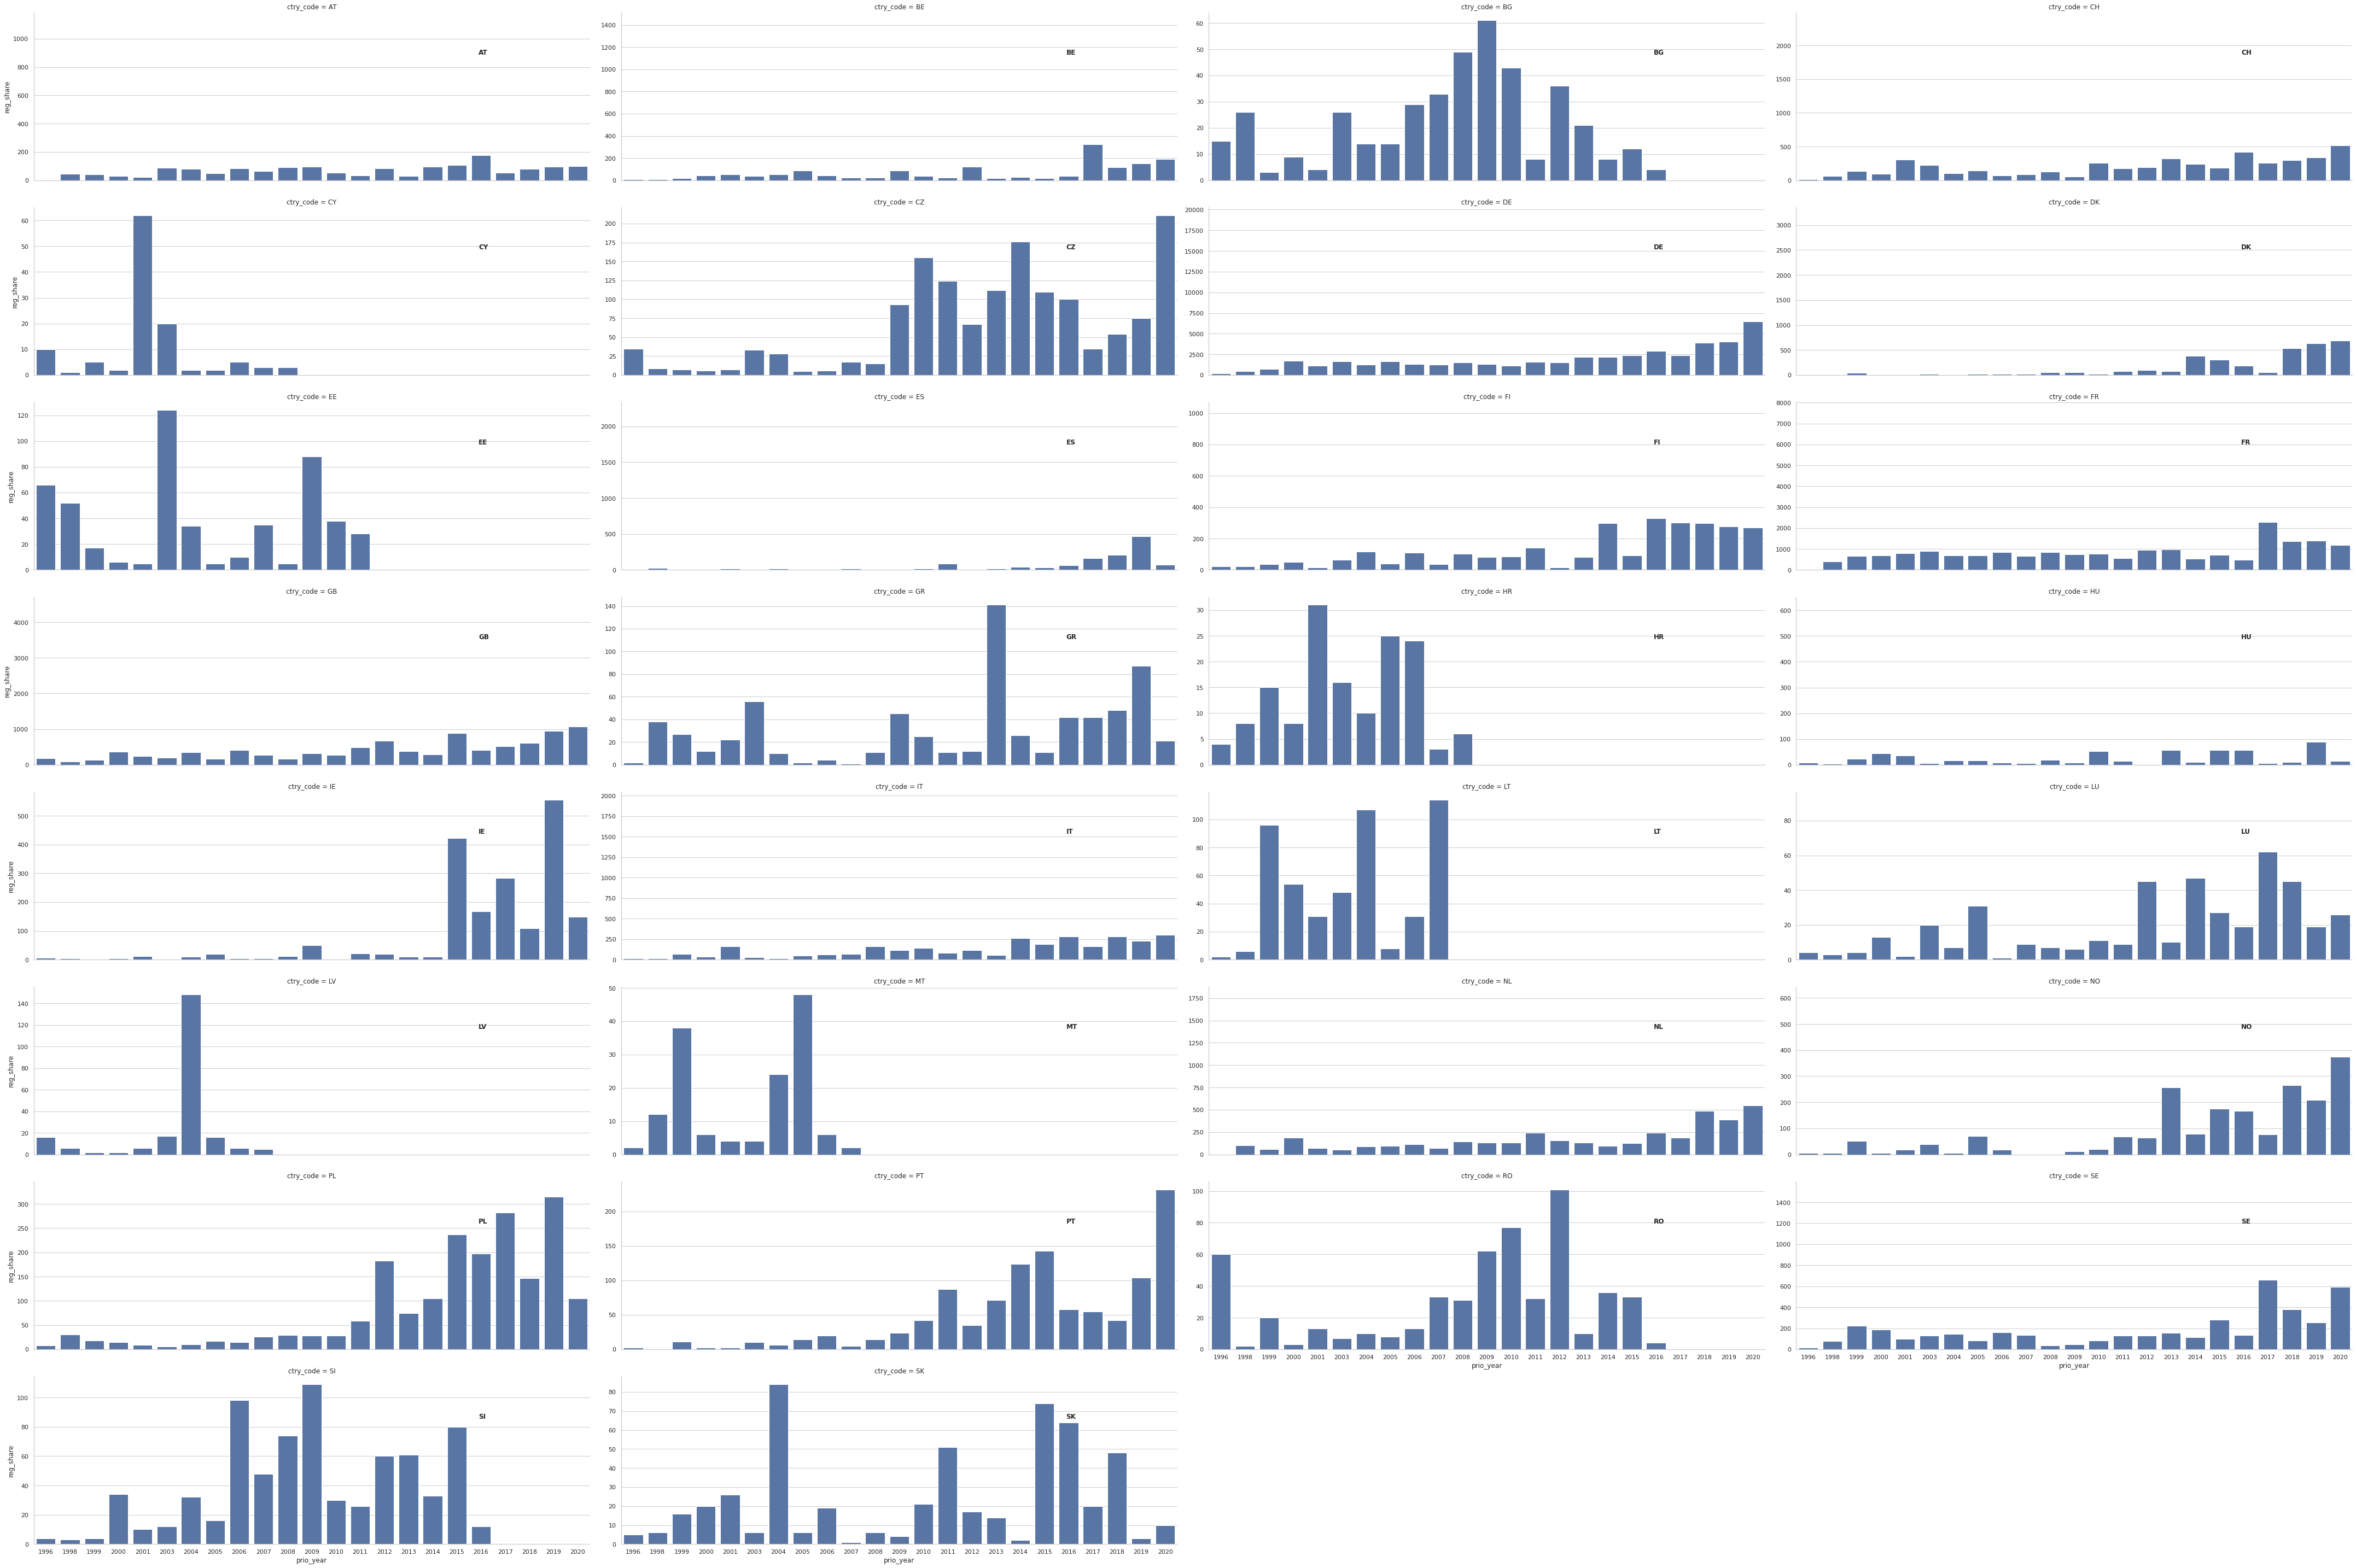

In [ ]:
g = sns.FacetGrid(eu_group, col='ctry_code', col_wrap=4, height=5, aspect=3, sharey = False, sharex = True, palette = "tab20c") 
g.map(sns.barplot, 'prio_year', 'reg_share')

# Iterate over each subplot to customize further
for ctry_code, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

In [ ]:
merged_sample = merged1.loc[merged1['ctry_code'].isin(['AT', 'BE', 'BR', 'CA', 'CH', 'CN', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE',
      'IT', 'JP', 'KR','LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'SE', 'SI',  'SK', 'ZA'])]

In [ ]:
jp = merged1.loc[merged1['ctry_code'].isin(['JP'])]

NameError: ignored

In [ ]:
g = sns.FacetGrid(merged_sample, col='ctry_code', col_wrap=4, height=5, aspect=3, sharey = False, sharex = True, palette = "tab20c") 
g.map(sns.barplot, 'prio_year', 'reg_share')

# Iterate over each subplot to customize further
for ctry_code, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


## Citation counts

In [ ]:
cit_counts = pd.read_csv('/content/202208_EPO_CIT_COUNTS.txt', encoding ='utf-8', sep = '|')

In [ ]:
cit_counts.columns

Index(['EP_Pub_nbr', 'EP_Pub_date', 'EP_Appln_id', 'WO_Pub_nbr', 'WO_Appln_id',
       'EP_Grant', 'Withdrawal', 'Refusal', 'EP_Pat_Cits', 'EP_NPL_Cits',
       'WO_Pat_Cits', 'WO_NPL_Cits', 'Total_Pat_Cits', 'Total_NPL_Cits',
       'Total_Cits', 'EP_Pat_XCits', 'EP_NPL_XCits', 'WO_Pat_XCits',
       'WO_NPL_XCits', 'Total_Pat_XCits', 'Total_NPL_XCits', 'Total_XCits',
       'Recd_asEP_byEP', 'Recd_asWO_byEP', 'Recd_asEP_byWO', 'Recd_asWO_byWO',
       'Direct_cits_Recd', 'Recd_asEQV_byEP', 'Recd_asEQV_byWO',
       'Total_cits_Recd', 'Recd_in3_asEP', 'Recd_in3_asWO',
       'Direct_cits_Recd_in3', 'Recd_in3_asEQV', 'Total_cits_Recd_in3'],
      dtype='object')

### Interesting variables: 
 - Direct_cits_Recd_in3 Total citations received within 3 years as either EP or WO publication
 - Total_cits_Recd_in3 All citations received [25]+[26]

 Both can be considered as forward citations


## Quality Indicators

In [ ]:
epo_qual = pd.read_csv('/content/202208_OECD_PATENT_QUALITY_EPO_INDIC.txt', encoding ='utf-8', sep = '|')

In [ ]:
epo_qual.head()

,appln_id,app_nbr,filing,tech_field,many_field,patent_scope,family_size,grant_lag,bwd_cits,npl_cits,...,fwd_cits7,fwd_cits7_xy,breakthrough,breakthrough_xy,generality,originality,radicalness,renewal,quality_index_4,quality_index_6
0,16427085,EP19780100001,1978,16.0,1,3,7,1203.0,4,0,...,4,0,NaN,NaN,0.705247,0.793388,0.090909,13.0,0.383706,0.406093
1,16427086,EP19780100002,1978,31.0,0,1,3,783.0,3,0,...,1,0,NaN,NaN,0.000000,0.500000,0.000000,6.0,0.207331,0.272474
2,16427087,EP19780100003,1978,32.0,1,2,1,NaN,7,0,...,1,0,NaN,NaN,NaN,0.704082,0.428571,2.0,NaN,NaN
3,16427088,EP19780100004,1978,14.0,1,4,8,783.0,1,1,...,1,0,NaN,NaN,0.693878,0.666667,0.000000,6.0,0.260275,0.299739
4,16427089,EP19780100005,1978,8.0,0,1,4,699.0,4,0,...,1,0,NaN,NaN,0.000000,0.459834,0.000000,6.0,0.145969,0.294256


In [ ]:
len(epo_qual)

3912957

In [ ]:
epo_qual_filt = epo_qual.loc[:, ['appln_id', 'filing', 'family_size', 'grant_lag', 'fwd_cits5', 'fwd_cits5_xy', 'fwd_cits7', 'fwd_cits7_xy', 'quality_index_4', 'quality_index_6']]

In [ ]:
epo_qual_filt.head()

,appln_id,filing,family_size,grant_lag,fwd_cits5,fwd_cits5_xy,fwd_cits7,fwd_cits7_xy,quality_index_4,quality_index_6
0,16427085,1978,7,1203.0,3,0,4,0,0.383706,0.406093
1,16427086,1978,3,783.0,1,0,1,0,0.207331,0.272474
2,16427087,1978,1,NaN,0,0,1,0,NaN,NaN
3,16427088,1978,8,783.0,1,0,1,0,0.260275,0.299739
4,16427089,1978,4,699.0,1,0,1,0,0.145969,0.294256


In [ ]:
# merge quality data with EU 

merged_all = pd.merge(merged1, merged_ipc_cpc, how='left', on= 'appln_id')

merged_qual = pd.merge(merged_all, epo_qual_filt, how='left', on= 'appln_id')

In [ ]:
# smaller sample 

merged_qual = pd.merge(merged_regpat, epo_qual_filt, how='left', on= 'appln_id')

In [ ]:
merged_qual['family_size'].unique()

array([ 5,  4,  6,  8,  1,  7, 10, 11,  3, 18, 12,  2,  9, 13, 15, 16, 17,
       14, 24, 23, 27, 36, 20, 22, 19, 37, 28, 21, 26, 25, 30, 29, 32])

In [ ]:
merged_qual.head()

,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,...,CPC_Class,filing,family_size,grant_lag,fwd_cits5,fwd_cits5_xy,fwd_cits7,fwd_cits7_xy,quality_index_4,quality_index_6
0,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,...,Y02E 60/10,1997,5,4431.0,5,2,5,2,0.453248,0.437998
1,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,...,Y02E 60/10,1997,5,4431.0,5,2,5,2,0.453248,0.437998
2,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,...,Y02E 60/10,1997,5,4431.0,5,2,5,2,0.453248,0.437998
3,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,...,Y02E 60/10,1997,5,4431.0,5,2,5,2,0.453248,0.437998
4,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,...,Y02E 60/10,1997,5,4431.0,5,2,5,2,0.453248,0.437998


Interesting variables:
- Patent quality index 4 – 4 components: number of forward citations (up to 5 years afterpublication); patent family size; number of claims; and the patent generality index. Only granted patents are covered by the index.
- Patent quality index 4b – 4 components, bis: number of forward citations (up to 5 years after publication); patent family size; corrected claims; and the patent generality index. Only granted patents are covered by the index.
- Patent quality index 6 – 6 components: covers the same components as above, plus the number of backward citations and the grant lag index.
- 

## REGPAT - PCT


In [ ]:
pct_inv_filt = pd.read_csv("/content/drive/My Drive/pct_inv_filt.csv", encoding = "utf-8", sep = ",")

pct_inv_us = pct_inv_filt.loc[pct_inv_filt['ctry_code'] == 'US', ].drop_duplicates()

In [ ]:
pct_ipc = pd.read_csv("/content/drive/MyDrive/202208_PCT_IPC.txt", encoding = "utf-8", sep = "|")

# pct_noipc = pct_ipc.loc[:, ['pct_nbr', 'prio_year', 'app_year', 'IPC']].drop_duplicates()

In [ ]:
len(pct_inv_us)

2063496

In [ ]:
len(pct_ipc)

14887452

In [ ]:
# merge pct_ipc with pct inventors data: we have country and year information

merged_ipc_inv = pd.merge(pct_inv_us, pct_ipc, how='left', on= 'pct_nbr')

merged_ipc_inv.head()

,pct_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC
0,WO1978000001,46895317.0,US11001,US,1.0,1.0,1977,1978,C08J005/22
1,WO1978000001,46895317.0,US11001,US,1.0,1.0,1977,1978,C03B019/12
2,WO1978000001,46895317.0,US11001,US,1.0,1.0,1977,1978,G21F009/12
3,WO1978000001,46895317.0,US11001,US,1.0,1.0,1977,1978,C12H001/044
4,WO1978000001,46895317.0,US11001,US,1.0,1.0,1977,1978,B01D039/20


In [ ]:
len(merged_ipc_inv)

8446701

In [ ]:
merged_ipc_inv.isna().value_counts() # 13 nas for appln_id

pct_nbr  appln_id  reg_code  ctry_code  reg_share  inv_share  prio_year  app_year  IPC  
False    False     False     False      False      False      False      False     False    8445469
                                                                                   True        1137
         True      False     False      False      False      False      False     False         94
                                                                                   True           1
dtype: int64

In [ ]:
merged_ipc_inv = merged_ipc_inv.dropna()

merged_ipc_inv = merged_ipc_inv.astype({'appln_id':'int'}) # transform appln_id from numerical to integer for merging 

print(merged_ipc_inv.dtypes)

pct_nbr       object
appln_id       int64
reg_code      object
ctry_code     object
reg_share    float64
inv_share    float64
prio_year      int64
app_year       int64
IPC           object
dtype: object


In [ ]:
# merge ipc_inv with y02e CPC class 

merged_ipc_y02e = pd.merge(merged_ipc_inv, cpc_y02e, how='left', on= 'appln_id')

merged_ipc_y02e = merged_ipc_y02e.dropna()

merged_ipc_y02e.head()

,pct_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC,CPC_Class
35,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/79,Y02E 10/40
36,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/72,Y02E 10/40
57,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/40
58,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/47
59,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,G02B007/182,Y02E 10/40


In [ ]:
len(merged_ipc_y02e)

334787

In [ ]:
regpat_regions.rename(columns = {'Ctry_code':'ctry_code'}, inplace = True) # rename col

reg_pct = pd.merge(merged_ipc_y02e, regpat_regions, how='left', on=['ctry_code', 'reg_code']).drop_duplicates()

reg_pct.head()

,pct_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC,CPC_Class,reg_label,Up_reg_code,Up_reg_label
0,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/79,Y02E 10/40,"Montgomery County, MD",US24,Maryland
1,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/72,Y02E 10/40,"Montgomery County, MD",US24,Maryland
2,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/40,"Montgomery County, MD",US24,Maryland
3,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/47,"Montgomery County, MD",US24,Maryland
4,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,G02B007/182,Y02E 10/40,"Montgomery County, MD",US24,Maryland


In [ ]:
len(reg_pct['appln_id'].unique()) # number of patent applications at PCT  

36313

In [ ]:
len(reg_pct)

334785

In [ ]:
reg_pct.isna().value_counts()

pct_nbr  appln_id  reg_code  ctry_code  reg_share  inv_share  prio_year  app_year  IPC    CPC_Class  reg_label  Up_reg_code  Up_reg_label
False    False     False     False      False      False      False      False     False  False      False      False        False           334785
dtype: int64

In [ ]:
reg_pct.to_csv('pct_aggregated.csv', sep = ",", index = False) # csv with all aggregated data

## Create patent counts

In [ ]:
reg_pct_filt = reg_pct[['Up_reg_label', 'prio_year','inv_share', 'appln_id']].drop_duplicates()

print(len(reg_pct_filt))

print(reg_pct_filt.head())

45519
   Up_reg_label  prio_year  inv_share  appln_id
0      Maryland       1977        1.0  46895330
2      Maryland       1977        1.0  46895343
12      Florida       1977        1.0  46895351
13   New Jersey       1977        1.0  46895349
17     Maryland       1977        1.0  46895401


In [ ]:
pct_counts = reg_pct_filt.groupby(['Up_reg_label', 'prio_year', 'appln_id'], as_index = False).inv_share.sum()

In [ ]:
pct_counts_2 = pct_counts.groupby(['Up_reg_label','prio_year'], as_index = False).inv_share.sum()

pct_counts_2.head()

,Up_reg_label,prio_year,inv_share
0,Alabama,1989,0.200000
1,Alabama,1990,1.000000
2,Alabama,1993,0.500000
3,Alabama,1994,0.833333
4,Alabama,1995,0.200000


In [ ]:
pct_counts_2.to_csv('pct_patent_counts.csv', index = False, sep = ",")

### Try to visualize - these graphs are crap 

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Plot the lines on two facets
g = sns.relplot(
    data= df_group,
    x="prio_year", y= "reg_share", 
    col="Up_reg_label",
    kind="scatter", 
    palette= "tab20c",
    col_wrap= 5,
    markers = True,
    linewidth=0.5,
    height=5, aspect=3, facet_kws=dict(sharex=True, sharey = True))

# Iterate over each subplot to customize further
for Up_reg_label, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, Up_reg_label, transform=ax.transAxes, fontweight="bold") 

# Add lineplot
g.map(plt.plot, "prio_year", "reg_share", marker="o", color = "#9f2a63", linewidth=0.7)

g.set_axis_labels(x_var="Year", y_var="Regional patent share")

g.set_titles("")
g.figure.suptitle("REGPAT patent regional share - US State level", y= 1)

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


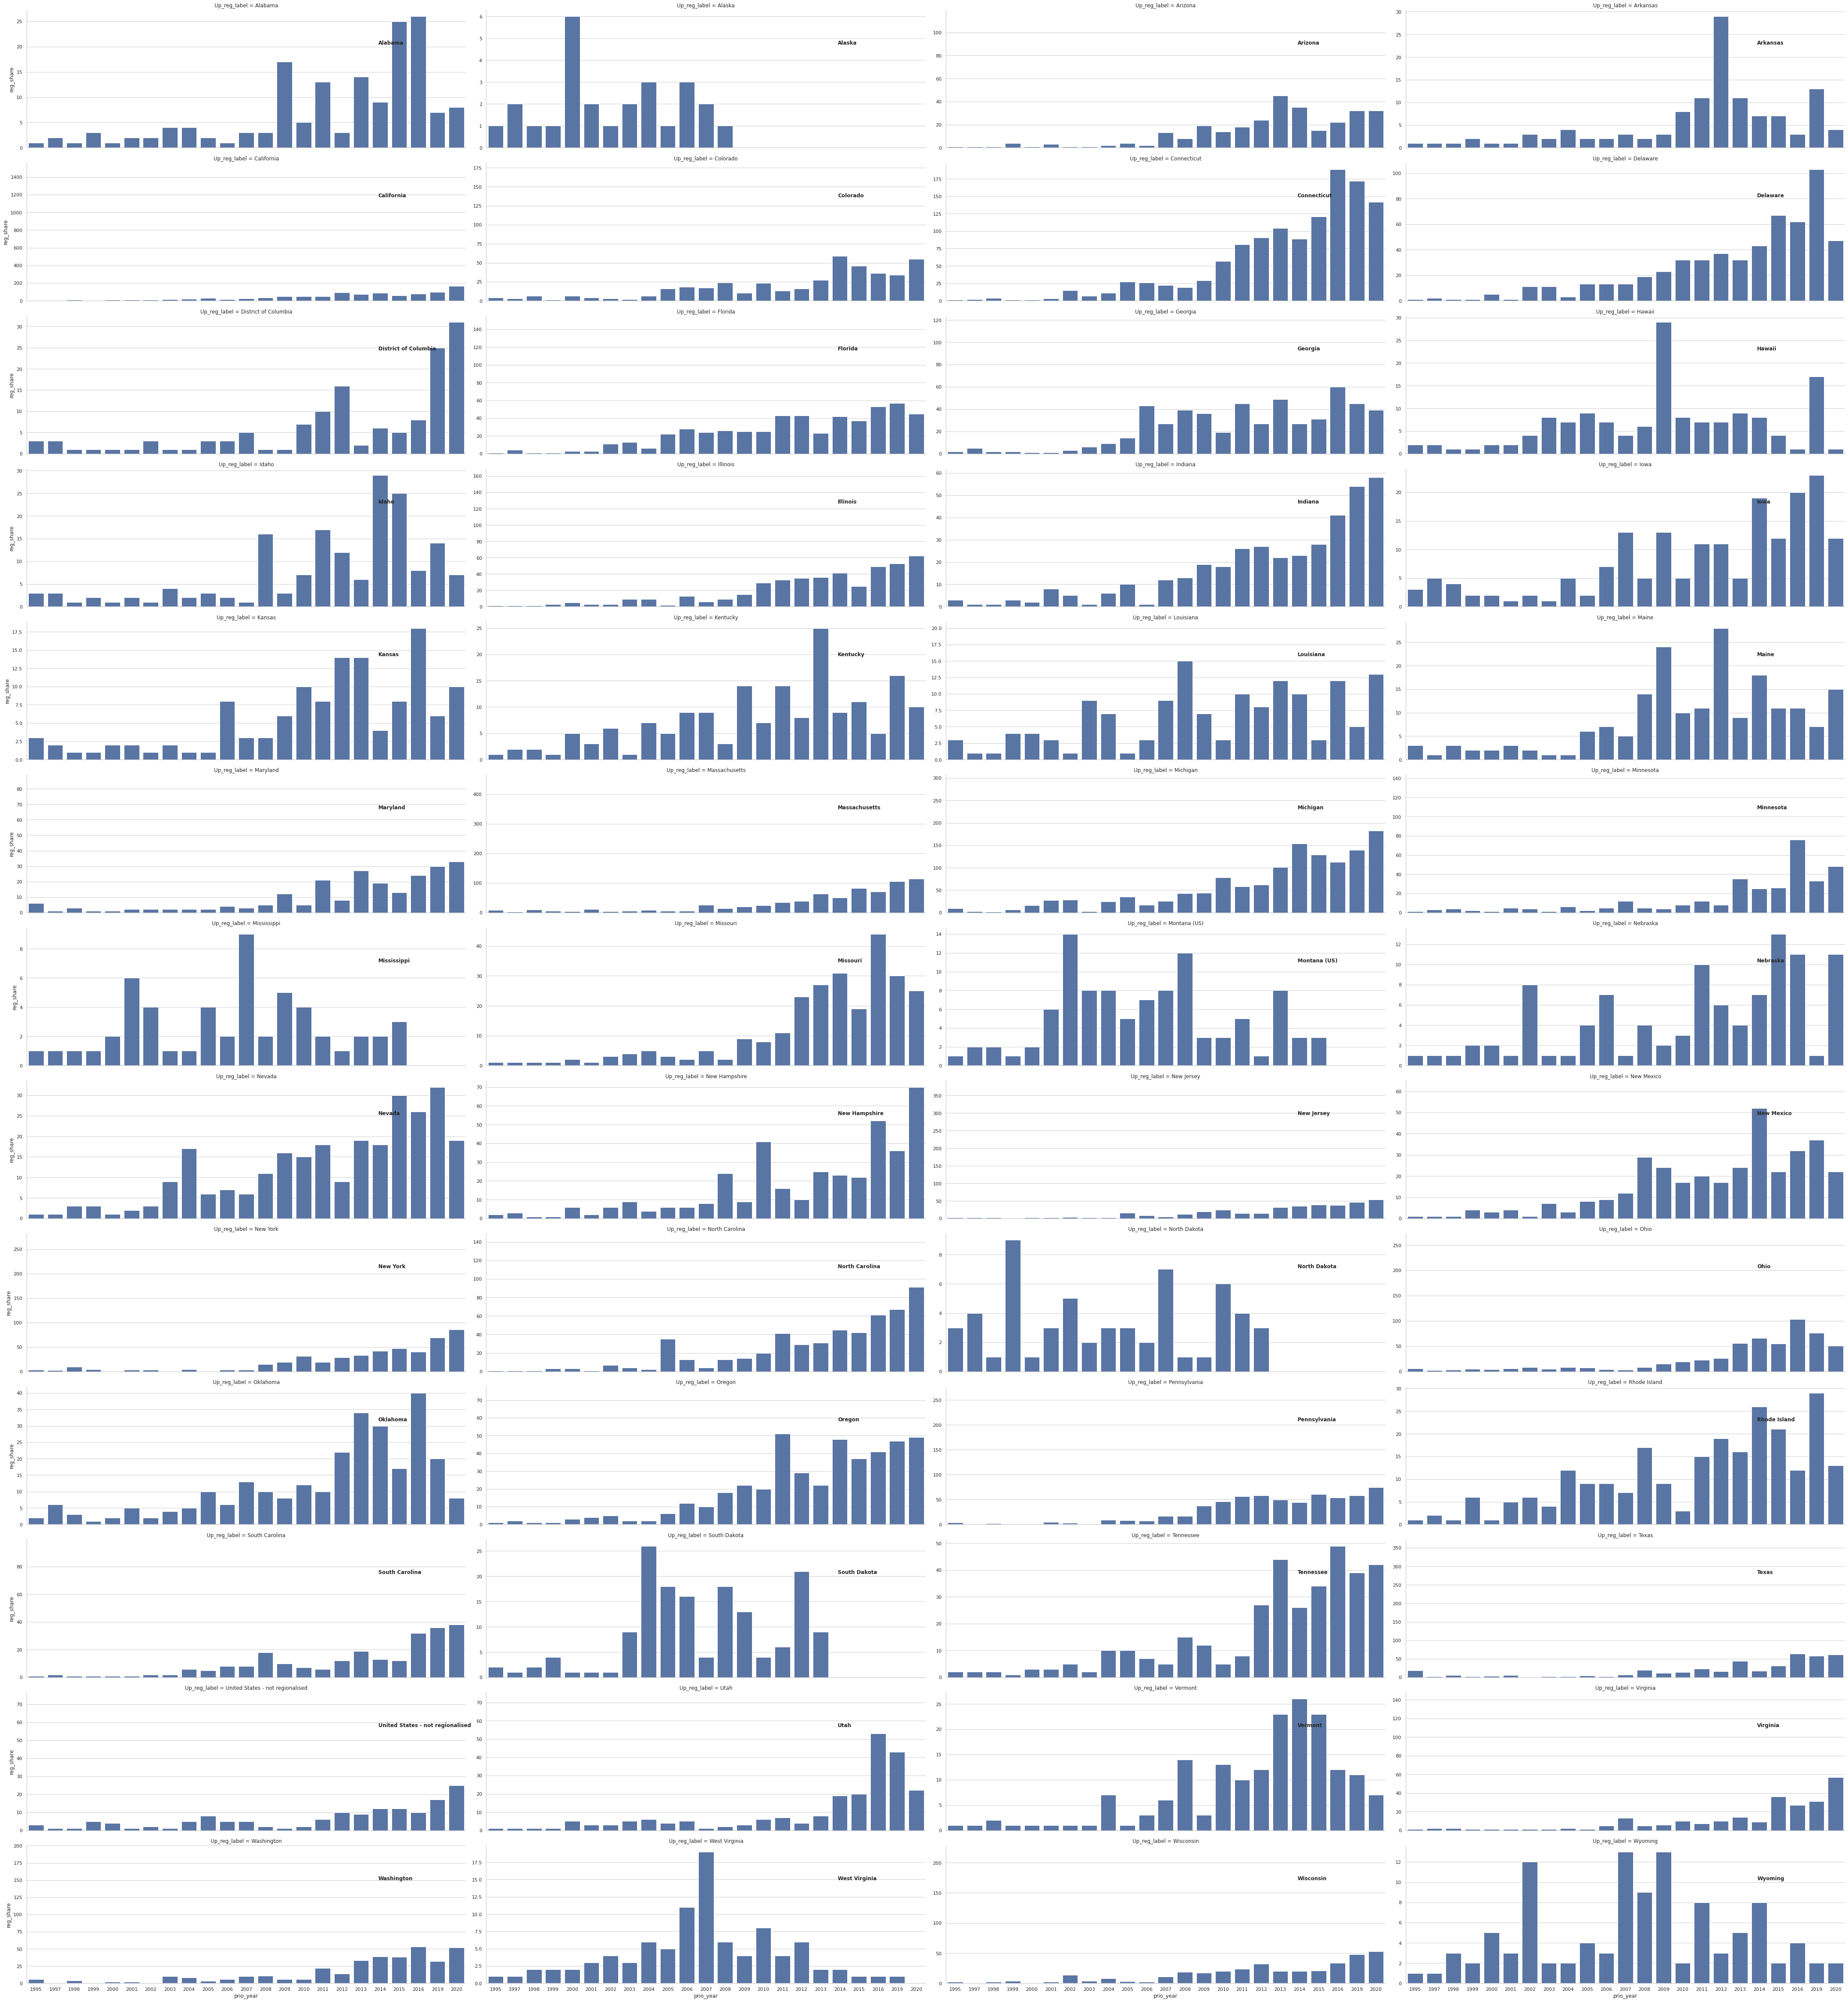

In [ ]:
us = sns.FacetGrid(df_group, col='Up_reg_label', col_wrap=4, height=5, aspect=3, sharey = False, sharex = True, palette = "tab20c", xlim = (1976, 2019)) 
us.map(sns.barplot, 'prio_year', 'reg_share')

# Iterate over each subplot to customize further
for ctry_code, ax in us.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .75, ctry_code, transform=ax.transAxes, fontweight="bold") 

## EPO-PCT overlap 

In [ ]:
epo_pct = pd.read_csv("/content/202208_EPO_PCT.txt", encoding = "utf-8", sep = "|")

In [ ]:
epo_pct.head()

,app_nbr,pct_nbr
0,EP20060731531,WO2007116521
1,EP20060731769,WO2006123491
2,EP20060731774,WO2006112357
3,EP20060731835,WO2006117999
4,EP20060732001,WO2006115104


In [ ]:
len(epo_pct)

4154295

In [ ]:
epo = pd.read_csv("/content/epo_regpat_agg.csv")
epo.head()

,Unnamed: 0,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,app_year,IPC,CPC_Class
0,95,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,B62B003/14,Y02E 60/10
1,96,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/00,Y02E 60/10
2,97,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/08,Y02E 60/10
3,98,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/10,Y02E 60/10
4,99,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K017/00,Y02E 60/10


In [ ]:
len(epo['app_nbr'].unique())  

27577

In [49]:
# check intersection between EPO patents filtered for US and PCT patents that entered EPO regional phase 

A = set(epo['app_nbr']) 
B = set(epo_pct['app_nbr'])
print(len(A.intersection(B)))
pct_epo_common = A.intersection(B) # 18313 

18313


## Check whether filing date is the same

In [108]:
common_epo = epo[epo['app_nbr'].isin(pct_epo_common)]

In [109]:
print(len(common_epo['appln_id'].unique()))

print(len(common_epo))

18313
210918


In [110]:
# For the patents which have both an EPO and a PCT application, is the filing date the same? 

common_con_pctnbr = pd.merge(common_epo, epo_pct, how = 'left', on = ['app_nbr'])

print(len(common_con_pctnbr))

common_con_pctnbr.head()

210918


,Unnamed: 0,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,app_year,IPC,CPC_Class,pct_nbr
0,147,EP20020795916,1357,US18097,US,1.0,0.25,"Marion County, IN",US18,Indiana,2002,2002,B01D053/94,Y02E 60/50,WO2003064833
1,148,EP20020795916,1357,US18097,US,1.0,0.25,"Marion County, IN",US18,Indiana,2002,2002,B01J019/08,Y02E 60/50,WO2003064833
2,149,EP20020795916,1357,US18097,US,1.0,0.25,"Marion County, IN",US18,Indiana,2002,2002,C01B003/34,Y02E 60/50,WO2003064833
3,150,EP20020795916,1357,US18097,US,1.0,0.25,"Marion County, IN",US18,Indiana,2002,2002,F01N003/02,Y02E 60/50,WO2003064833
4,151,EP20020795916,1357,US18097,US,1.0,0.25,"Marion County, IN",US18,Indiana,2002,2002,F01N003/025,Y02E 60/50,WO2003064833


In [111]:
common_epo_filt = common_con_pctnbr[['prio_year', 'pct_nbr']].drop_duplicates()

print(common_epo_filt.head())

pct_filt = pct[['prio_year', 'pct_nbr']].drop_duplicates()

print(pct_filt.head())

     prio_year       pct_nbr
0         2002  WO2003064833
51        2002  WO2004013868
59        2002  WO2004051774
71        2004  WO2005083829
139       2004  WO2005109551
    prio_year       pct_nbr
0        1977  WO1978000019
2        1977  WO1979000018
12       1977  WO1979000028
13       1977  WO1979000030
17       1977  WO1979000140


In [112]:
# find equal pct_nbr between the two dfs and check if the prio_year is the same 

tupla1 = zip(common_con_pctnbr['prio_year'], common_con_pctnbr['pct_nbr'])
tupla2 = zip(pct_filt['prio_year'], pct_filt['pct_nbr'])

In [113]:
A = set(tupla1) 
B = set(tupla2)
print(len(A.intersection(B)))
epo_pct_year_same = A.intersection(B)

18214


## Remove overlapping patents in the EPO data 

In [44]:
if ('EP20020022517' in pct_epo_common):  # test
      print("Element Exists")
else:
        print("noooo")

noooo


In [114]:
epo_extra = epo[~epo['app_nbr'].isin(pct_epo_common)] # drop matching application numbers from epo aggregated regpat 

In [40]:
print(len(epo_extra)) 

len(epo_extra['app_nbr'].unique()) # 9264 patents are direct applications from US to EPO

87904


9264

In [45]:
epo_extra.head()

,Unnamed: 0,app_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,reg_label,Up_reg_code,Up_reg_label,prio_year,app_year,IPC,CPC_Class
0,95,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,B62B003/14,Y02E 60/10
1,96,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/00,Y02E 60/10
2,97,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/08,Y02E 60/10
3,98,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K007/10,Y02E 60/10
4,99,EP20020022517,1297,US48339,US,1.0,0.5,"Montgomery County, TX",US48,Texas,1996,1997,G06K017/00,Y02E 60/10


## Concatenate overlapping direct EPO patents with PCT patents

In [13]:
pct = pd.read_csv("/content/pct_aggregated.csv")

In [26]:
len(pct['appln_id'].unique())

36313

In [116]:
pct.head()

,pct_nbr,appln_id,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC,CPC_Class,reg_label,Up_reg_code,Up_reg_label
0,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/79,Y02E 10/40,"Montgomery County, MD",US24,Maryland
1,WO1978000019,46895330,US24031,US,1.0,1.0,1977,1978,F24S023/72,Y02E 10/40,"Montgomery County, MD",US24,Maryland
2,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/40,"Montgomery County, MD",US24,Maryland
3,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,F24J002/54,Y02E 10/47,"Montgomery County, MD",US24,Maryland
4,WO1979000018,46895343,US24031,US,1.0,1.0,1977,1978,G02B007/182,Y02E 10/40,"Montgomery County, MD",US24,Maryland


In [51]:
filt_pct = pct[['Up_reg_label', 'prio_year','inv_share', 'appln_id']].drop_duplicates()

print(filt_pct.head())

filt_epo = epo_extra[['Up_reg_label', 'prio_year','inv_share', 'appln_id']].drop_duplicates()

print(filt_epo.head())

   Up_reg_label  prio_year  inv_share  appln_id
0      Maryland       1977        1.0  46895330
2      Maryland       1977        1.0  46895343
12      Florida       1977        1.0  46895351
13   New Jersey       1977        1.0  46895349
17     Maryland       1977        1.0  46895401
     Up_reg_label  prio_year  inv_share  appln_id
0           Texas       1996        0.5      1297
10           Ohio       1996        0.5      1297
177      New York       2005        0.5      1978
208      Maryland       2007        0.1      3345
211  Pennsylvania       2007        0.1      3345


In [52]:
# merge pct patent counts and patent counts from direct applications from us to epo 

pct_counts = filt_pct.groupby(['Up_reg_label','prio_year', 'appln_id'], as_index = False).inv_share.sum() # create pct counts 

print(pct_counts.head())

direct_epo_counts = filt_epo.groupby(['Up_reg_label','prio_year', 'appln_id'], as_index = False).inv_share.sum() # create direct epo counts

print(direct_epo_counts.head())

  Up_reg_label  prio_year  appln_id  inv_share
0      Alabama       1989  47131572   0.200000
1      Alabama       1990  47157149   1.000000
2      Alabama       1993  47253815   0.500000
3      Alabama       1994  47272348   0.333333
4      Alabama       1994  47283317   0.500000
  Up_reg_label  prio_year  appln_id  inv_share
0      Alabama       1978  16436864       0.50
1      Alabama       1986  16664403       1.00
2      Alabama       1988  16787177       0.25
3      Alabama       1991  16944498       1.00
4      Alabama       1992  17009326       0.25


In [56]:
print(len(pct_counts))
print(len(direct_epo_counts))

45519
11427


In [55]:
# concatenate the two dataframes 

pct_direct_epo_all = pd.concat([pct_counts,direct_epo_counts], ignore_index= True, axis = 0)

pct_direct_epo_all.head()

,Up_reg_label,prio_year,appln_id,inv_share
0,Alabama,1989,47131572,0.200000
1,Alabama,1990,47157149,1.000000
2,Alabama,1993,47253815,0.500000
3,Alabama,1994,47272348,0.333333
4,Alabama,1994,47283317,0.500000


In [58]:
len(pct_direct_epo_all)

print(len(pct_direct_epo_all['appln_id'].unique()))

45577


In [60]:
pct_direct_epo_all.to_csv('patent_count_pct_direct_epo.csv', index = False, sep = ",")

## Patent count without appln_id

In [63]:
pct_direct_epo_all_counts = pct_direct_epo_all.groupby(['Up_reg_label','prio_year'], as_index = False).inv_share.sum()

pct_direct_epo_all_counts.head()

pct_direct_epo_all_counts.to_csv('patent_count_pct_direct_epo_counts.csv', index = False, sep = ",")